In [1]:
# Importowanie wymaganych bibliotek
from sklearn.model_selection import train_test_split, cross_val_score
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from dask.distributed import Client, LocalCluster
import dask.dataframe as dd
import matplotlib.pyplot as plt
import pickle
import os

In [2]:
# Utworzenie lokalnych klasterów z 4 workerami
cluster = LocalCluster(n_workers=4, threads_per_worker=3, memory_limit="5GB")

# Łączymy się z klastrem
client = Client(cluster)

# Sprawdzamy status klastra
print(client)

<Client: 'tcp://127.0.0.1:49530' processes=4 threads=12, memory=18.63 GiB>


In [3]:
# Ładujemy dane
df = dd.read_parquet('output_directory/*.parquet')

# Sprawdzamy pierwsze wiersze
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,trip_duration,hour
0,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,...,1.0,0.5,4.00,0.0,1.0,16.90,2.5,0.0,379.0,0
1,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,...,1.0,0.5,15.00,0.0,1.0,34.90,2.5,0.0,765.0,0
2,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,...,1.0,0.5,3.28,0.0,1.0,19.68,2.5,0.0,650.0,0
3,2,2023-01-01 00:50:34,2023-01-01 01:02:52,1.0,1.84,1.0,N,161,137,1,...,1.0,0.5,10.00,0.0,1.0,27.80,2.5,0.0,738.0,0
4,2,2023-01-01 00:09:22,2023-01-01 00:19:49,1.0,1.66,1.0,N,239,143,1,...,1.0,0.5,3.42,0.0,1.0,20.52,2.5,0.0,627.0,0


In [4]:
# Wybieramy 10% danych losowo
df_sample = df.sample(frac=0.10, random_state=42)

In [5]:
# # Wybieramy cechy i cel dla x%
# X = df_sample[['trip_distance', 'fare_amount', 'passenger_count', 'hour', 'payment_type', 'RatecodeID','trip_duration']]  
# y = df_sample['tip_amount']  # cel (napiwek)

# Wybieramy cechy i cel dla 100%
X = df[['trip_distance', 'fare_amount', 'passenger_count', 'hour', 'payment_type', 'RatecodeID', 'trip_duration']]  
y = df['tip_amount']  # cel (napiwek)

In [6]:
# # Sprawdzamy liczbę rekordów dla x%
# print(f"Liczba rekordów: {len(df_sample)}")

# Sprawdzamy liczbę rekordów dla 100%
print(f"Liczba rekordów: {len(df)}")

Liczba rekordów: 13951964


In [7]:
# Podział na dane treningowe i testowe
X_train, X_test, y_train, y_test = train_test_split(X.compute(), y.compute(), test_size=0.2, random_state=42)

# Sprawdzamy rozmiary
print(f"Treningowy X: {X_train.shape}, Testowy X: {X_test.shape}")

Treningowy X: (11161571, 7), Testowy X: (2790393, 7)


In [8]:
# Walidacja krzyżowa - LightGBM
lgb_model = LGBMRegressor(random_state=42)
lgb_cv_score = cross_val_score(lgb_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print(f"Średni MAE (walidacja krzyżowa): {-lgb_cv_score.mean()}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.109565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 8929256, number of used features: 7
[LightGBM] [Info] Start training from score 4.219663
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.102209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 704
[LightGBM] [Info] Number of data points in the train set: 8929257, number of used features: 7
[LightGBM] [Info] Start training from score 4.219529
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.098030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

In [9]:
# Trening modelu LightGBM
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.121920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 699
[LightGBM] [Info] Number of data points in the train set: 11161571, number of used features: 7
[LightGBM] [Info] Start training from score 4.219243


LGBMRegressor(random_state=42)

In [10]:
# Przewidywanie i ocena
lgb_predictions = lgb_model.predict(X_test)

lgb_mae = mean_absolute_error(y_test, lgb_predictions)
lgb_mse = mean_squared_error(y_test, lgb_predictions)
lgb_rmse = np.sqrt(lgb_mse)
lgb_r2 = r2_score(y_test, lgb_predictions)

print(f"Średni błąd bezwzględny: {lgb_mae}")
print(f"Średni błąd kwadratowy (MSE): {lgb_mse}")
print(f"Pierwiastek z błędu kwadratowego (RMSE): {lgb_rmse}")
print(f"Współczynnik determinacji R2: {lgb_r2}")

Średni błąd bezwzględny: 0.9924152349837672
Średni błąd kwadratowy (MSE): 2.53884302958009
Pierwiastek z błędu kwadratowego (RMSE): 1.5933747298046652
Współczynnik determinacji R2: 0.7392152685517916


In [11]:
# Sprawdź, czy folder 'models' istnieje, jeśli nie, to go utwórz
os.makedirs('models', exist_ok=True)

# Zapisz model do pliku
with open('models/lightgbm_regressor_model.pkl', 'wb') as f:
    pickle.dump(lgb_model, f)

In [12]:
# Zamykanie klastra po zakończeniu pracy
client.close()
cluster.close()

Liczba odrzuconych danych z dolnej strony: 27903
Liczba odrzuconych danych z górnej strony: 27904
Łączna liczba odrzuconych danych: 55807


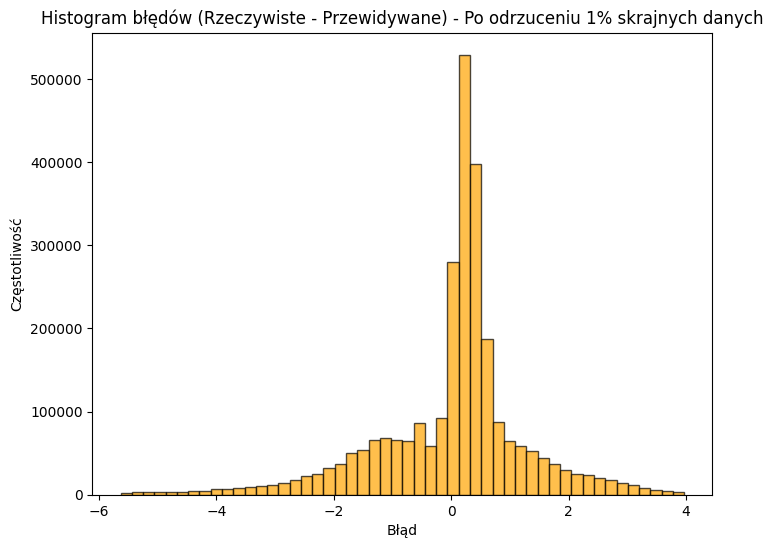

In [13]:
# Błędy między rzeczywistymi i przewidywanymi wartościami
errors = y_test - lgb_predictions

# Sortowanie błędów
sorted_errors = np.sort(errors)

# Odrzucenie 1% skrajnych danych (z obu stron)
lower_bound = int(0.01 * len(sorted_errors))
upper_bound = int(0.99 * len(sorted_errors))

# Liczenie liczby odrzuconych danych
num_rejected_lower = lower_bound
num_rejected_upper = len(sorted_errors) - upper_bound

# Wybór danych bez skrajnych 1% (z obu stron)
filtered_errors = sorted_errors[lower_bound:upper_bound]

# Wypisanie liczby odrzuconych danych
print(f"Liczba odrzuconych danych z dolnej strony: {num_rejected_lower}")
print(f"Liczba odrzuconych danych z górnej strony: {num_rejected_upper}")
print(f"Łączna liczba odrzuconych danych: {num_rejected_lower + num_rejected_upper}")

# Tworzymy histogram
plt.figure(figsize=(8, 6))
plt.hist(filtered_errors, bins=50, edgecolor='black', alpha=0.7, color='orange')
plt.title("Histogram błędów (Rzeczywiste - Przewidywane) - Po odrzuceniu 1% skrajnych danych")
plt.xlabel("Błąd")
plt.ylabel("Częstotliwość")
plt.show()

# Podsumowanie

1. Dla próbki danych 10% (Czas treningu 4.7s)

 - Średni MAE (walidacja krzyżowa): 0.9909729145668902 (Czas: 1.0s)
 - Średni błąd bezwzględny: 0.9880331392420096
 - Średni błąd kwadratowy (MSE): 3.4691939159116076
 - Pierwiastek z błędu kwadratowego (RMSE): 1.8625772241471246
 - Współczynnik determinacji R2: 0.7091634676484526

2. Dla próbki danych 100% (Czas treningu 14.1s)

 - Średni MAE (walidacja krzyżowa): 0.9884444730287398 (Czas: 1m 3s)
 - Średni błąd bezwzględny: 0.9889143452341757
 - Średni błąd kwadratowy (MSE): 3.505883673574363
 - Pierwiastek z błędu kwadratowego (RMSE): 1.8724005109950068
 - Współczynnik determinacji R2: 0.7065057982754493